In [1]:
import os
import sys

import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from matplotlib import gridspec

get_ipython().magic(u'matplotlib inline')

sys.path.append('../score')
from containers import Dataset
from score_query import ScoreQuery
from utils import *#export, show_side_by_side, load_score_file
from statistics import *
from prob_opt import LigSet, PredictStructs

sys.path.append('../dock')
from parse_chembl import load_chembl_raw, load_chembl_proc
from core_proc import load_matches

In [33]:
data = '/scratch/PI/rondror/jbelk/method/data'
glide_dir = 'docking/glide12'
ifp_dir = 'ifp/ifp2'
mcss_dir = 'mcss/mcss1'

struct_dict = {'D2R':'6CM4','AR':'2PNU','A2AR':'2YDO','B1AR':'2VT4','B2AR':'2RH1','CHK1':'2BRN', 'PLK1':'2OWB',
               'VITD':'2HB7','BRAF':'3IDP','JAK2':'3KRR','CDK2':'1H1S','ERA':'1A52','GCR':'3K23'}

features = {
    'mcss':[],
    'hbond':[3],
    'sb':[4],
    'pipi':[6]
    #'contact':[11]
}

In [34]:
stats_prots = ['B1AR']
pred_prot = 'D2R'
load_prots = list(set(stats_prots + [pred_prot]))

num_poses = 100

all_data = Dataset(data, load_prots)
all_data.load_docking(glide_dir, ifp_dir, mcss_dir, structs=struct_dict,
                      load_fp=True, load_crystal=False, load_chembl=True, load_mcss=True)

stats = Statistics(all_data, stats_prots, 20, 100, features)

no ki found for CHEMBL567_lig drug?
no ki found for CHEMBL2219425_lig drug?
no ki found for CHEMBL1200940_lig drug?
no ki found for CHEMBL1200587_lig drug?
no ki found for CHEMBL1201154_lig drug?
no ki found for CHEMBL1201102_lig drug?
no ki found for CHEMBL1200902_lig drug?
no ki found for CHEMBL1201074_lig drug?
no ki found for CHEMBL3544974_lig drug?
no ki found for CHEMBL1200792_lig drug?
no ki found for CHEMBL1201_lig drug?
no ki found for CHEMBL2105760_lig drug?
no ki found for CHEMBL1201052_lig drug?
no ki found for CHEMBL1200911_lig drug?
no ki found for CHEMBL14376_lig drug?
no ki found for CHEMBL570_lig drug?
no ki found for CHEMBL2107117_lig drug?
no ki found for CHEMBL1200419_lig drug?
no ki found for CHEMBL1621_lig drug?
no ki found for CHEMBL2358147_lig drug?
no ki found for CHEMBL1615372_lig drug?
no ki found for CHEMBL1201087_lig drug?
no ki found for CHEMBL1200854_lig drug?
no ki found for CHEMBL1712_lig drug?
no ki found for CHEMBL1200707_lig drug?
no ki found for CHE

sb


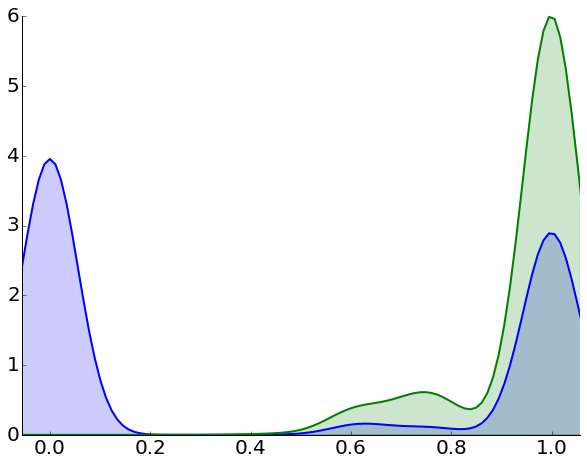

mcss


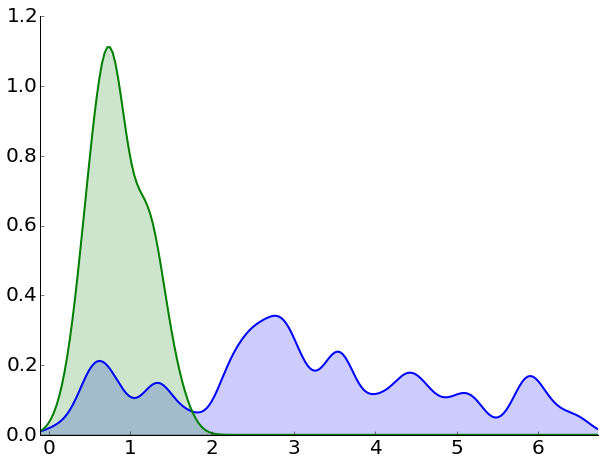

pipi


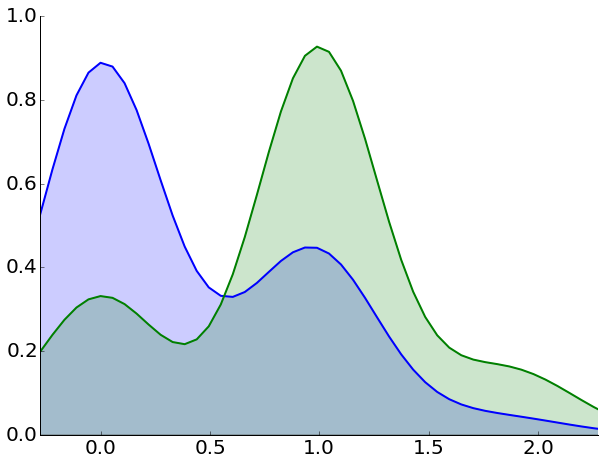

In [20]:
for f_name in features.keys():
    print f_name
    stats.show_stats(f_name, raw=False, smoothed=True)

In [35]:
for s, st in all_data.proteins[pred_prot].docking.items():
    
    l_list = ['CHEMBL{}_lig'.format(x) for x in [1108,2107117,267930,267932,135832,1423]]
    pred_ligs = {l:st.ligands[l] for l in l_list} # 54, 297302

    ls = LigSet(pred_ligs, num_poses, features, st.mcss, t=10)

    ps = PredictStructs(ls, stats.evidence, features)
    best_cluster, en_landscape = ps.max_posterior(verbose=True, sampling=3, en_landscape=False)

cluster -1, prob = -300.727404073
cluster 0, prob = -300.727404073
cluster 1, prob = -300.727404073
cluster 2, prob = -300.727404073
cluster 3, prob = -321.056622823
cluster 4, prob = -304.678738004
cluster 5, prob = -321.056622823
cluster 6, prob = -300.727404073
cluster 7, prob = -300.727404073
cluster 8, prob = -321.056622823
cluster 9, prob = -321.056622823
cluster 10, prob = -302.059120954
cluster 11, prob = -304.678738004
cluster 12, prob = -300.727404073
cluster 13, prob = -302.059120954
cluster 14, prob = -300.727404073


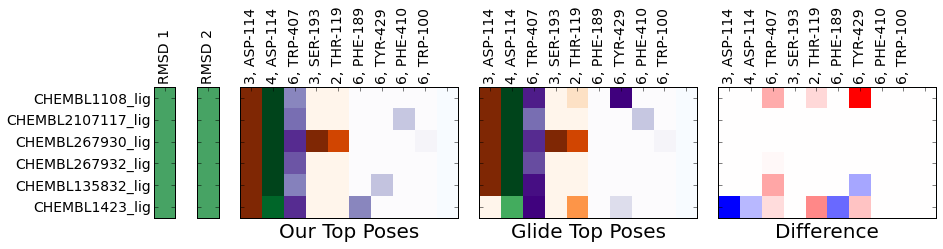

In [37]:
us_top = {l:lig.poses[best_cluster[l]] for l,lig in pred_ligs.items()}
glide_top = {l:lig.poses[0] for l,lig in pred_ligs.items()}

all_data.assign_weights({2:1,3:1,4:1,6:1,11:0.001})

show_side_by_side(us_top, glide_top, l_list, 
                  t1='Our Top Poses', t2='Glide Top Poses', num_i=10)

In [32]:
# this will show up in /scratch/PI/rondror/jbelk/method/outputs

export(data, us_top, 'd2r_us_20182003_2', pred_prot, 
       struct=struct_dict[pred_prot], verbose=False, glide_dir=glide_dir)
#export(data, glide_top, 'd2r_glide_20182003', pred_prot, 
#       struct=struct_dict[pred_prot], verbose=False, glide_dir=glide_dir)

In [13]:
def show_side_by_side(c1, c2, sorted_ligs, t1='Cluster 1', t2='Cluster 2', num_i=15):
    i_key, fp_mat1 = get_fp_matrix(c1, sorted_ligs, num_i=num_i)
    i_key, fp_mat2 = get_fp_matrix(c2, sorted_ligs, all_i=i_key, num_i=num_i)
    fp_mat3 = fp_mat2 - fp_mat1

    heat_max = max(np.max(fp_mat1), np.max(fp_mat2))

    r_mat1 = get_rmsd_matrix(c1, sorted_ligs)
    r_mat2 = get_rmsd_matrix(c2, sorted_ligs)

    f, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1, 5, gridspec_kw = {'width_ratios':[1,1]+[num_i]*3}, dpi=400)

    ax0.matshow(r_mat1, cmap='Set1', vmin=0, vmax=9)
    ax0.set_yticks(np.arange(len(sorted_ligs)), minor=False)
    ax0.set_yticklabels(sorted_ligs, minor=False, size=14)

    ax1.matshow(r_mat2, cmap='Set1', vmin=0, vmax=9)
    ax1.set_yticks(np.arange(len(sorted_ligs)), minor=False)

    interaction_heatmap(fp_mat1, sorted_ligs, i_key, m=heat_max, fig=f, ax=ax2)
    interaction_heatmap(fp_mat2, sorted_ligs, i_key, m=heat_max, fig=f, ax=ax3)
    interaction_heatmap(fp_mat3, sorted_ligs, i_key, fig=f, ax=ax4, difference=True)

    ax0.set_xticks(np.arange(1), minor=False)
    ax0.xaxis.tick_top()
    ax0.set_xticklabels(['RMSD 1'], minor=False, rotation = 'vertical', size=14)
    ax1.set_xticks(np.arange(1), minor=False)
    ax1.xaxis.tick_top()
    ax1.set_xticklabels(['RMSD 2'], minor=False, rotation = 'vertical', size=14)

    ax2.set_xlabel(t1, size=20)
    ax3.set_xlabel(t2, size=20)
    ax4.set_xlabel('Difference', size=20)

    ax1.set_yticklabels(['' for i in sorted_ligs])
    ax2.set_yticklabels(['' for i in sorted_ligs])
    ax3.set_yticklabels(['' for i in sorted_ligs])
    ax4.set_yticklabels(['' for i in sorted_ligs])

    plt.tight_layout()
    plt.show()

def interaction_heatmap(A, structs, res, fname='', m=None, fig=None, ax=None, difference=False):
    sq_size = 0.9
    if fig is None:
        fig, ax = plt.subplots()
        sq_size = 0.3

    fig.set_size_inches(sq_size*15, sq_size*15, forward=True)

    def i_matrix(A, res, i):
        aa = np.zeros(A.shape)
        for j, r in enumerate(res):
            if r[0] == i: aa[:,j] = A[:,j]
            else: aa[:,j] = np.nan*A[:,j]
        return aa

    colors = {2:cm.Oranges, 3:cm.Oranges,11:cm.Greys, 13:cm.Oranges, 14:cm.Oranges, 7:cm.Purples,
              8:cm.Greens, 9:cm.Greens, 6:cm.Purples, 4:cm.Greens, 5:cm.Purples, 10:cm.Blues}

    if difference:
        max_abs = np.max(np.abs(A))
        ax.matshow(A, cmap='bwr', vmin=-max_abs, vmax=max_abs)
    else:
        if m is None: m = np.max(A)
        for i in range(20):
            ax.matshow(i_matrix(A, res, i), cmap=colors.get(i, cm.Blues), vmin=0, vmax=m)

    # put the major ticks at the middle of each cell
    ax.set_xticks(np.arange(A.shape[1]), minor=False)
    ax.set_yticks(np.arange(A.shape[0]), minor=False)
    ax.xaxis.tick_top()
    #print res
    xlabels = ['{}, {}-{}'.format(i, r.split('(')[1].split(')')[0], r.split(':')[1].split('(')[0]) for (i,r) in res]
    ax.set_xticklabels(xlabels, minor=False, rotation = 'vertical', size=14)
    ax.set_yticklabels(structs, minor=False, size=14)
                                                                    